In [315]:
import pandas as pd
import numpy as np
import synapseclient
import pylab as plt
import seaborn as sns
import scipy.stats as stats
import ipywidgets as widgets
# %matplotlib widget #breaks javascript in notebook

import create_summary

COMPLETION_COLS = ['wasCompleted', 'inSynapseParent', 'inStudyProject', 'inParquet', 'inScores']
DELTA_T_COLS = ['completion time [s]', 'export delay [s]', 'upload delay [s]', 'in Synapse delay [s]']

syn = synapseclient.login();

Welcome, Larsson Omberg!



In [475]:
# Load Data 
studies = create_summary.getStudies(syn)
df = pd.read_csv(syn.get('syn51185576').path, low_memory=False)
timeCols =  ['uploadedOn', 'finishedOn', 'startedOn', 'eventTimestamp_x', 'modifiedOn', 'createdOn', 'exportedOn', 'eventTimestamp_y']
df[timeCols] = df[timeCols].apply(pd.to_datetime)

#Fill in startedOn data for columns and remove fnamea
df = (df.assign(startedOn = np.where(df.startedOn.isnull(), df.uploadedOn, df.startedOn))
      .query("assessmentId!='fnamea'")
      .set_index('startedOn', drop=True))

df['completion time [s]'] = (df.finishedOn-df.index).map(lambda x:x.seconds)
df['export delay [s]'] = (df.exportedOn-df.finishedOn).map(lambda x:x.seconds)
df['upload delay [s]'] = (df.uploadedOn-df.finishedOn).map(lambda x:x.seconds)
df['in Synapse delay [s]'] = (df.createdOn-df.finishedOn).map(lambda x:x.seconds)



# Percent complete Data

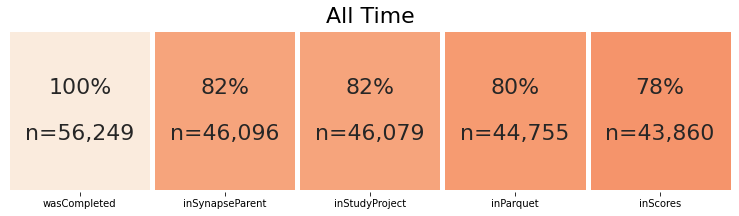

In [316]:
temp_df = df.dropna(subset=['wasCompleted'])[COMPLETION_COLS]
n_alltime = temp_df.sum()
pct_alltime = pd.DataFrame(n_alltime.div(n_alltime['wasCompleted'], axis=0)*100, columns=['All Time'])
labels_alltime = pd.DataFrame([f"{a:.0f}%\n\nn={b:,.0f}" for a, b in zip(pct_alltime['All Time'], n_alltime)])

plt.figure(figsize=(13,3))
#ax = sns.heatmap(pct_alltime.T, annot=True, fmt=".0f", cbar=False, linewidth=5, vmin=0);
ax = sns.heatmap(pct_alltime.T, annot=labels_alltime.T, fmt="s", cbar=False, linewidth=5, vmin=0,
                annot_kws={"fontsize":22});
plt.yticks([])
plt.title('All Time', fontsize=22);

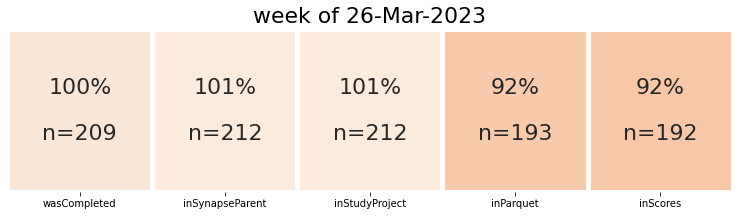

In [317]:
n_lastweek = temp_df.groupby(pd.Grouper(freq='W')).sum().iloc[-2]
legend = n_lastweek.name.strftime('week of %d-%b-%Y')
n_lastweek.name = legend
pct_lastweek  = pd.DataFrame(n_lastweek.div(n_lastweek['wasCompleted'], axis=0)*100)
labels_lastweek = pd.DataFrame([f"{a:.0f}%\n\nn={b:,.0f}" for a, b in zip(pct_lastweek[legend], n_lastweek)])

#n_lastweek
plt.figure(figsize=(13,3))
#ax = sns.heatmap(pct_lastweek.T, annot=True, fmt=".0f", cbar=False, linewidth=5,vmin=0);
ax = sns.heatmap(pct_lastweek.T, annot=labels_lastweek.T, fmt="s", cbar=False, linewidth=5, vmin=0,
                annot_kws={"fontsize":22});
plt.yticks([])
plt.title(legend, fontsize=22);

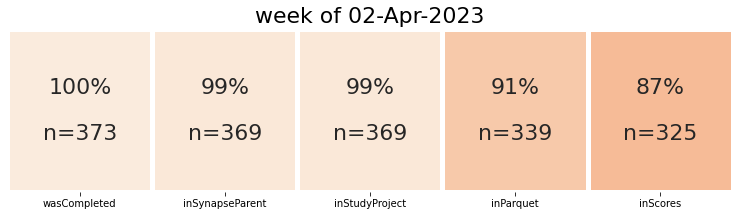

In [318]:
n_lastweek = temp_df.groupby(pd.Grouper(freq='W')).sum().iloc[-1]
legend = n_lastweek.name.strftime('week of %d-%b-%Y')
n_lastweek.name = legend
pct_lastweek  = pd.DataFrame(n_lastweek.div(n_lastweek['wasCompleted'], axis=0)*100)
labels_lastweek = pd.DataFrame([f"{a:.0f}%\n\nn={b:,.0f}" for a, b in zip(pct_lastweek[legend], n_lastweek)])

#n_lastweek
plt.figure(figsize=(13,3))
#ax = sns.heatmap(pct_lastweek.T, annot=True, fmt=".0f", cbar=False, linewidth=5,vmin=0);
ax = sns.heatmap(pct_lastweek.T, annot=labels_lastweek.T, fmt="s", cbar=False, linewidth=5, vmin=0,
                annot_kws={"fontsize":22});
plt.yticks([])
plt.title(legend, fontsize=22);

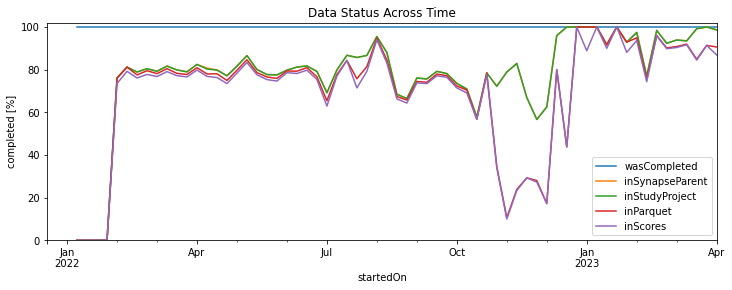

In [319]:
plt.figure(figsize=(12,4))
ax = plt.subplot(1,1,1)
(df.query("wasCompleted==1").groupby(pd.Grouper(freq='W'))[COMPLETION_COLS].mean()*100).plot(ax=ax)
plt.title('Data Status Across Time')
plt.ylim(0,102)
plt.ylabel('completed [%]');

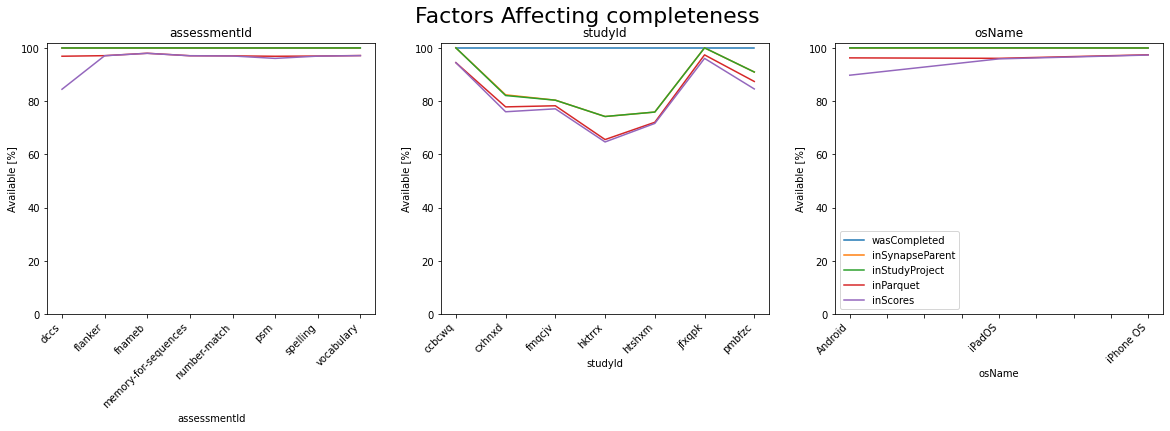

In [320]:
plt.figure(figsize=(20,5))
for i, label in enumerate(['assessmentId','studyId','osName']):
    ax = plt.subplot(1,3,i+1)
    (df.query("wasCompleted==1& osName!='Linux'").groupby(label)[COMPLETION_COLS].mean()*100).plot(ax=ax, legend=False)
    plt.ylabel('Available [%]')
    plt.title(label)
    plt.ylim(0,102)
    plt.xticks(rotation = 45, ha='right')
plt.legend()
plt.suptitle('Factors Affecting completeness', fontsize=22);

## Associations between missing data and conditions when collected
Evaluates whether there are any specific conditions that lead to a higher risk of missing data. For example whether the appVersion or the date is assoicated with data being missing in the **scores**. Can also be modified to identify other missingness for example in upload or parquet data. 

In [470]:

#Columns that are evaluated
correlated_columns=['assessmentId', 'studyId', 'appVersion','assessmentRevision', 'clientTimeZone', 'declined', 
                    'deviceName', 'languages','osName', 'osVersion', 'scheduleGuid', 'sessionGuid', 
                    'sessionInstanceGuid', 'sessionInstanceStartDay', 'sessionStartEventId', 'sharingScope']

@widgets.interact(stage_missing=['inScores', 'inParquet', 'inStudyProject'], 
                  end_date = df.index.max().strftime('%Y-%m-%d %X'),
                  p_cut_off=widgets.fixed(1e-3))
def find_correlated_variables(start_date='2023-03-01 00:00:00', end_date='2023-04-01 00:00:00', stage_missing='inScores', p_cut_off=0.001):
    """Filters the data by timeframe and compares the differences in missingness in a specific stage in
       pipeline.  Computes contigency tables and determines if differences are statistically significant and plot
       the odds of missing data.
       
    """
    temp_df = df[df.index > start_date].query('wasCompleted==1')
    temp_df = temp_df[temp_df.index<end_date]
    for variable in correlated_columns:

        #Create contigency table
        contigency = (temp_df[[stage_missing, variable]]
             .groupby(variable)[stage_missing]
             .value_counts()  #Count number of missing and nn missing
             .to_frame(name='available')      
             .reset_index(1)
             .pivot_table(columns=stage_missing, values='available', index=variable)
             .fillna(0)  #If there are no counts set the NaN to 0
             .rename(columns={1.0:'Present', 0.0:'Missing'})
        )
        # Filtering out any categories with too few measurements 
        contigency = contigency[contigency.sum(axis=1)>10]
        # Only continue of data is missing
        if 'Missing' not in contigency.columns:
            continue
        # Compute Chi-square statistic for missingness being different between groups
        # Assumption there is no relationship between variable and missingness
        chi2, p, dof, expected = stats.chi2_contingency(contigency)
    
        # odds of missing data = (# 0s)/(# 1s)
        contigency['Odds']=contigency['Missing']/contigency['Present']
    
        #Plot odds of missingness for each category if the p-value<0.001
        if p<p_cut_off:
            plt.figure(figsize=(13,6))
            ax=plt.subplot(2,1,1)
            contigency.plot(y='Odds', kind='bar', ax=ax);
            plt.ylabel('Odds of Missing')
            plt.title('%s p=%0.2g' %(variable, p))
            ax=plt.subplot(2,1,2)
            #Format table for display
            contigency['Odds'] = contigency['Odds'].apply('{:,.1f}'.format)
            contigency = contigency.astype({'Present': int, 'Missing': int})
            plt.table(cellText=contigency.values.T, colLabels=contigency.index, rowLabels=contigency.columns, loc='center')
            plt.axis('off');

interactive(children=(Text(value='2023-03-01 00:00:00', description='start_date'), Text(value='2023-04-02 18:5…

## Study Specific information
Filter down to a specific study and explore the data within that study

In [502]:
groups = df.groupby('studyId')
@widgets.interact(study=groups.groups.keys())
def plot_studies(study):
    plt.figure(figsize=(2,8))
    temp_df = groups.get_group(study)[COMPLETION_COLS]
    ax = plt.subplot(1,1,1)
    sns.heatmap(temp_df, cbar=False, ax=ax)
    ticklabels = ['NaT' if pd.isnull(temp_df.index[int(tick)]) else temp_df.index[int(tick)].strftime('%Y-%m-%d') for tick in ax.get_yticks()]
    ax.set_yticklabels(ticklabels);
    label = (studies.query("studyId=='%s'"%study)['name']+'('+ studies.query("studyId=='%s'"%study)['id'] + ')').iloc[0]
    plt.title(label)

interactive(children=(Dropdown(description='study', options=('ccbcwq', 'cxhnxd', 'fmqcjv', 'hktrrx', 'htshxm',…

In [522]:
@widgets.interact(study=groups.groups.keys(), stages=COMPLETION_COLS )
def show_participant_level_data(study='hktrrx', stages='inStudyProject'):
    return (df.query("studyId=='%s'" %study)
           .groupby(['externalId', 'sessionGuid'])[stages]
           .apply(sum).reset_index()
           .pivot(index='externalId', columns='sessionGuid')
           .fillna(0)
           .astype(int))
    

interactive(children=(Dropdown(description='study', index=3, options=('ccbcwq', 'cxhnxd', 'fmqcjv', 'hktrrx', …

## Timing information

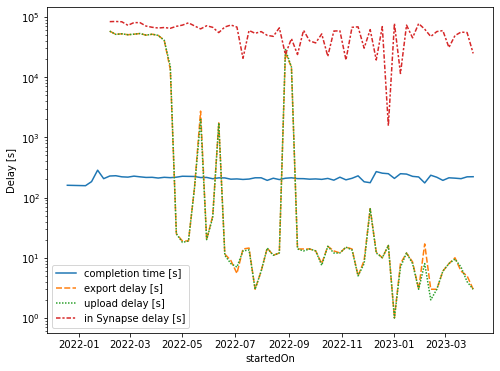

In [507]:
plt.figure(figsize=(8,6))
    
timing = df.groupby(pd.Grouper(freq='W'))[DELTA_T_COLS].median()
sns.lineplot(data=timing)
plt.ylabel('Delay [s]');
plt.yscale('log')
timing = timing.reset_index().melt(id_vars=['startedOn'])